# Waterbody prediction

If we fit a predictor to a waterbody, what does its error tell us about the time series? What if we fit a predictor to _all_ waterbodies?

In [96]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
import sklearn.linear_model
import pandas as pd
from tqdm.notebook import tqdm
import geopandas as gpd

%matplotlib inline

In [111]:
waterbodies = gpd.read_file('waterbodies_joined_drainage.shp').to_crs('EPSG:3577')

In [112]:
waterbodies = waterbodies.set_index('UID')
waterbodies.index = waterbodies.index.astype('|S9')

In [4]:
ts = h5py.File('interpolated_waterbodies_by_division.h5', mode='r')

In [15]:
test_series = ts['South Australian Gulf']['pc_wet'][0]

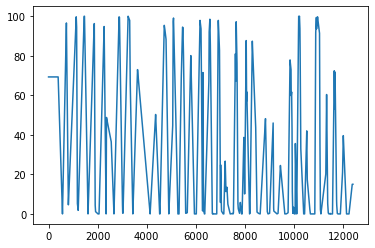

In [16]:
plt.plot(test_series)

Fit a linear predictor that uses the last 10 time steps to predict the next one. Use the gradient since it is wide-sense stationary.

In [54]:
Xs = []
ys = []

window_size = 10
step = 1
grad = np.gradient(test_series)
for i in range(0, len(test_series) - window_size, step):
    Xs.append(grad[i:i + window_size])
    ys.append(grad[i + window_size])

In [55]:
Xs = np.array(Xs)
ys = np.array(ys)

In [56]:
prd = sklearn.linear_model.LinearRegression()

In [57]:
prd.fit(Xs, ys)

LinearRegression()

In [58]:
predictions = prd.predict(Xs)

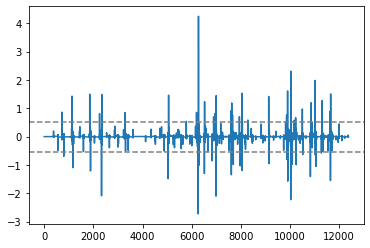

In [63]:
plt.plot(predictions - ys)
plt.axhline(5 * np.std(predictions - ys), linestyle='--', color='grey')
plt.axhline(-5 * np.std(predictions - ys), linestyle='--', color='grey')

In [65]:
unusual = abs(predictions - ys) > 5 * np.std(predictions - ys)

(10000.0, 13009.5)

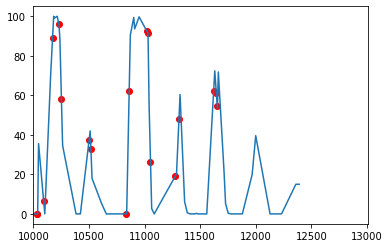

In [66]:
plt.plot(test_series)
for i in unusual.nonzero()[0]:
    plt.scatter(i, test_series[i], c='red', marker='o')
plt.xlim(10000, None)

This is pretty useless. Let's try training on everything.

In [69]:
Xs = []
ys = []
window_size = 10
step = 1

for test_series in tqdm(ts['South Australian Gulf']['pc_wet']):
    grad = np.gradient(test_series)
    for i in range(0, len(test_series) - window_size, step):
        Xs.append(grad[i:i + window_size])
        ys.append(grad[i + window_size])

In [71]:
Xs = np.nan_to_num(Xs)
ys = np.nan_to_num(ys)

In [72]:
prd = sklearn.linear_model.LinearRegression()
prd.fit(Xs, ys)

LinearRegression()

In [73]:
predictions = prd.predict(Xs)

In [74]:
mean = np.mean(predictions - ys)

In [77]:
std = np.std(predictions - ys)

In [92]:
errors = (predictions - ys).reshape(len(ts['South Australian Gulf']['pc_wet']), -1)

In [95]:
total_error = (errors ** 2).sum(axis=1)

In [100]:
ts['South Australian Gulf'].keys()

<KeysViewHDF5 ['pc_wet', 'uid']>

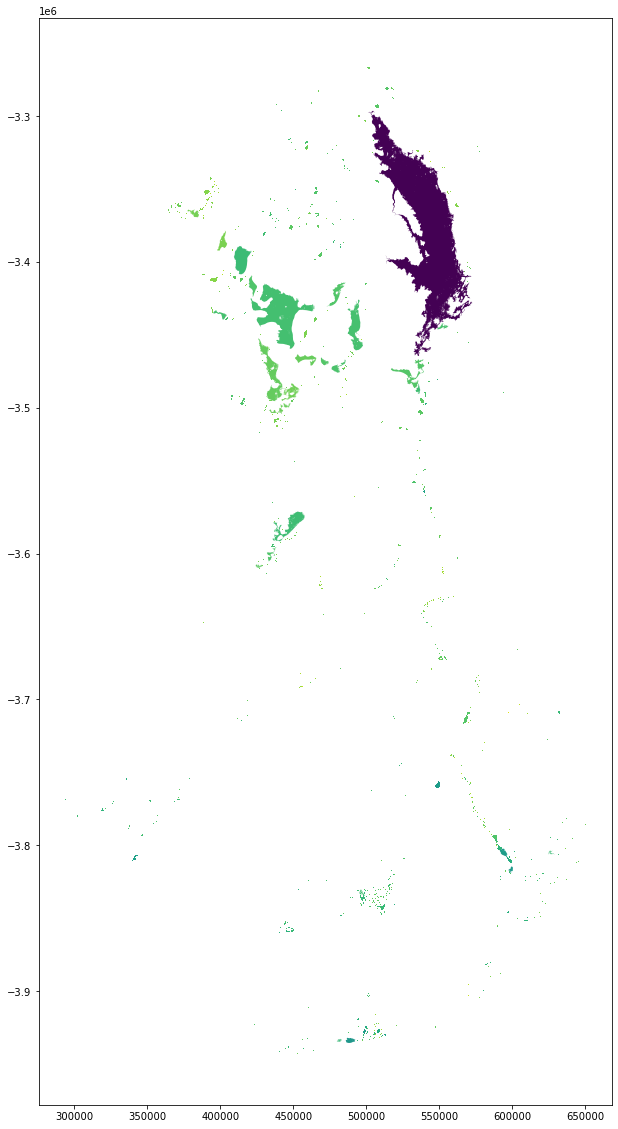

In [120]:
fig = plt.figure(figsize=(20, 20))
waterbodies.loc[ts['South Australian Gulf']['uid'][()]].plot(column=np.log10(total_error / max(total_error)), ax=fig.add_subplot(1, 1, 1))